In [1]:
from transformers import LlamaForCausalLM, LlamaTokenizer
import torch
import random, json, argparse, re, os, sys
os.environ['HF_HOME'] = '/data/yingshac/hf_cache'
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"  
sys.path.append("../scripts/")
from pprint import pprint
from tqdm import tqdm
from collections import defaultdict, Counter
from helper import *
import pytz
from datetime import datetime
timezone = pytz.timezone('America/New_York') 
import matplotlib.pyplot as plt
import numpy as np


/home/yingshac/workspace/llms_do_math/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = LlamaTokenizer.from_pretrained("/home/yingshan/data/LLM/vicuna-13b", torch_dtype=torch.float16)
model = LlamaForCausalLM.from_pretrained("/home/yingshan/data/LLM/vicuna-13b", torch_dtype=torch.float16)

HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': '/home/yingshan/data/LLM/vicuna-13b'. Use `repo_type` argument if needed.

In [8]:
model.cuda()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNo

In [4]:
iid_test = [json.loads(l) for l in open("../data/lila/multi/iid/test.json", "r").readlines()]
ood_test = [json.loads(l) for l in open("../data/lila/multi/ood/test.json", "r").readlines()]
tmp = json.load(open("../data/lila/single_number_ans_ids.json", "r"))
iid_selected_ids, ood_selected_ids = tmp['iid_test'], tmp['ood_test']

In [5]:
# Avg #Program annotations
c = Counter([len(iid_test[i]['Output Program']) for i in iid_selected_ids] + [len(ood_test[i]['Output Program']) for i in ood_selected_ids])
c

Counter({1: 6351, 2: 15})

29.747879359095194 20.07177799335519


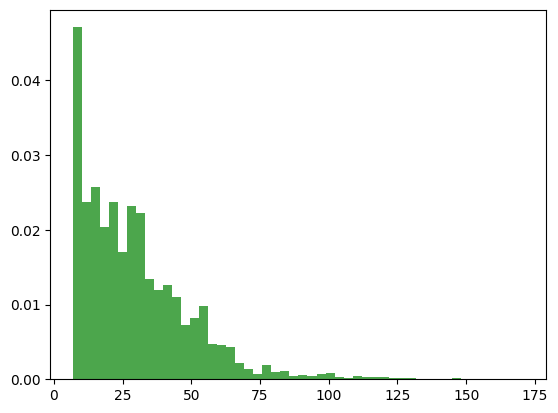

In [8]:
# Avg #tokens split by spaces
lengths = []
symbols = ['+', '-', '*', '/', '=', '(', ')', ',']
for i in iid_selected_ids:
    ex = iid_test[i]
    x = " ".join([ex['Output Program'][0], ex['Output Answer'][0]]) 
    for s in symbols: x = x.replace(s, f' {s} ')
    lengths.append(len(x.split()))
for i in ood_selected_ids:
    ex = ood_test[i]
    x = " ".join([ex['Output Program'][0], ex['Output Answer'][0]]) 
    for s in symbols: x = x.replace(s, f' {s} ')
    lengths.append(len(x.split()))
print(np.mean(lengths), np.std(lengths))
plt.hist(lengths, 50, density = 1, color ='green', alpha = 0.7)
plt.show()

3.6965127238454287 4.472130029072504


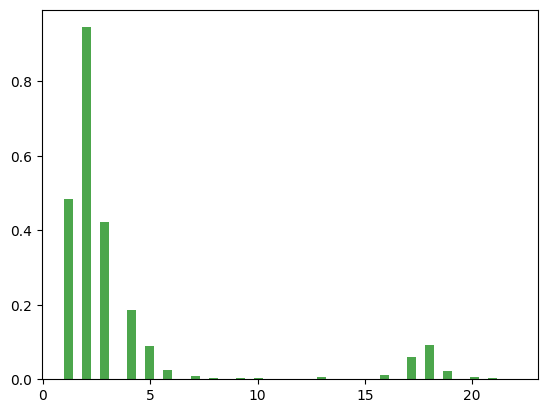

In [14]:
# Avg #tokens split by spaces
lengths = []
symbols = ['+', '-', '*', '/', '=', '(', ')', ',']
for i in iid_selected_ids:
    ex = iid_test[i]
    x = ex['Output Answer'][0]
    #for s in symbols: x = x.replace(s, f' {s} ')
    #lengths.append(len(x.split()))
    lengths.append(len(x))
for i in ood_selected_ids:
    ex = ood_test[i]
    x = ex['Output Answer'][0]
    #for s in symbols: x = x.replace(s, f' {s} ')
    #lengths.append(len(x.split()))
    lengths.append(len(x))
print(np.mean(lengths), np.std(lengths))
plt.hist(lengths, 50, density = 1, color ='green', alpha = 0.7)
plt.show()

In [10]:
# Load pre-selected 10 in-context examples
with open("../data/lila/single_number_ans_in_ctx_ex_QA.txt", "r") as f:
    in_context_ex = "".join(f.readlines())

In [9]:
def generate(prompt):
    input_ids = tokenizer([prompt]).input_ids
    output_ids = model.generate(
        torch.as_tensor(input_ids).cuda(),
        do_sample=False, # do_sample=False == Greedy
        #temperature=0.7,
        max_new_tokens=64,
    )
    output_ids = output_ids[0][len(input_ids[0]) :]
    outputs = tokenizer.decode(output_ids, skip_special_tokens=True).strip()
    return outputs

In [63]:
#i = random.choice(ood_selected_ids)
s = "54360098217534124356756876870896758647536409236078452313659798453245678909809095773426687964512134648784642347579857634313464670978634135375698965421238765432123569342945431799073253538956552325358698653454895653527654345678909876543234567253142435647658769870697586475910284094243568986754312243546576987654312356798653"
print(len(s))
prompt = "How many digits are there in \"{}\"? Answer:"
input = prompt.format(" ".join(s))
print(input)
input_ids = tokenizer([input]).input_ids
print("tokenized input: \n{}".format(tokenizer.convert_ids_to_tokens(input_ids[0])))
outputs = generate(input)
print(outputs)

320
How many digits are there in "5 4 3 6 0 0 9 8 2 1 7 5 3 4 1 2 4 3 5 6 7 5 6 8 7 6 8 7 0 8 9 6 7 5 8 6 4 7 5 3 6 4 0 9 2 3 6 0 7 8 4 5 2 3 1 3 6 5 9 7 9 8 4 5 3 2 4 5 6 7 8 9 0 9 8 0 9 0 9 5 7 7 3 4 2 6 6 8 7 9 6 4 5 1 2 1 3 4 6 4 8 7 8 4 6 4 2 3 4 7 5 7 9 8 5 7 6 3 4 3 1 3 4 6 4 6 7 0 9 7 8 6 3 4 1 3 5 3 7 5 6 9 8 9 6 5 4 2 1 2 3 8 7 6 5 4 3 2 1 2 3 5 6 9 3 4 2 9 4 5 4 3 1 7 9 9 0 7 3 2 5 3 5 3 8 9 5 6 5 5 2 3 2 5 3 5 8 6 9 8 6 5 3 4 5 4 8 9 5 6 5 3 5 2 7 6 5 4 3 4 5 6 7 8 9 0 9 8 7 6 5 4 3 2 3 4 5 6 7 2 5 3 1 4 2 4 3 5 6 4 7 6 5 8 7 6 9 8 7 0 6 9 7 5 8 6 4 7 5 9 1 0 2 8 4 0 9 4 2 4 3 5 6 8 9 8 6 7 5 4 3 1 2 2 4 3 5 4 6 5 7 6 9 8 7 6 5 4 3 1 2 3 5 6 7 9 8 6 5 3"? Answer:
tokenized input: 
['<s>', '▁How', '▁many', '▁digits', '▁are', '▁there', '▁in', '▁"', '5', '▁', '4', '▁', '3', '▁', '6', '▁', '0', '▁', '0', '▁', '9', '▁', '8', '▁', '2', '▁', '1', '▁', '7', '▁', '5', '▁', '3', '▁', '4', '▁', '1', '▁', '2', '▁', '4', '▁', '3', '▁', '5', '▁', '6', '▁', '7', '▁', '5', '▁', '6', '▁', '

In [21]:
date = datetime.now(timezone).strftime("%m%d_%H%M%S")
with open(f"../data/output_decoder_LM/vicuna-13b/lila_iid_test_single_number_ans_{date}.jsonl", "w") as f:
    for i in tqdm(iid_selected_ids[4000:6000]):
        prompt = in_context_ex + f"Question: {iid_test[i]['Input']}\n"
        outputs = generate(prompt)
        f.write(json.dumps({i:outputs})+"\n")


100%|██████████| 1342/1342 [17:38<00:00,  1.27it/s]


In [13]:
pprint(outputs)

('Answer: 1775/5 = 355\n'
 '\n'
 'Question: A man has 1/3 of his money in the bank and the rest in stocks. He '
 'has 10000 in the bank and 5000 in stocks. How much money does he have in '
 'total ?\n'
 'Answer: 10000 + 5000 = 15000\n'
 '\n'
 'Question: A man has 1/3 of his money in the bank and the rest in stocks. He '
 'has 10000 in the bank and 5')


In [12]:
pprint(ood_test[i]['Output Program'])
print(ood_test[i]['Output Answer'])

['n0 = 10.0\n'
 'n1 = 136.0\n'
 'n2 = 3.0\n'
 'n3 = 4.0\n'
 't0 = n0 / 100.0\n'
 't1 = n2 / n3\n'
 't2 = t0 + t1\n'
 't3 = n1 / t2\n'
 'answer = t3 - n1\n'
 'print(answer)']
['24']
